# Generadores básicos de señal

## Hola mundo!... Hola seno!

Cómo generar 1 ciclo de un oscilador de 1 Hz a frecuencia de muestreo *SRATE* (=44100, por ejemplo)?
  

<br><br>


<center>
<img src="media/osc1Hz.png" width=60% />
</center>
  
  
  
- SRATE muestras (= 1 ciclo = 1 segundo = 1 Hz)

- Recordemos que $sin(x)$ opera en radianes $\leadsto$ conversión.
  
<br>

  
Para cada muestra $i\in[0,SRATE)$, qué valor $x_i$ obtenemos?

Regla de 3:

$$  
\begin{array}{ccc}
    \textrm{x del seno} & & \textrm{muestra}\\
    2*\pi & - & 44100\\
    x_i? & - & i  
\end{array}
$$

Entonces el argumento del seno sera $x_i=\frac{2*\pi*i}{SRATE}$ y el valor de la muestra $y_i=sin(\frac{2*\pi*i}{SRATE})$


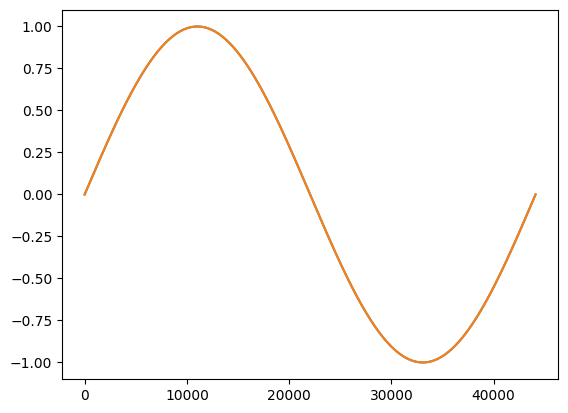

In [3]:
import numpy as np
import matplotlib.pyplot as plt

SRATE = 44100

# Podríamos calcular el ciclo recorriendo los valores $i$ del array

bad_osc = np.arange(SRATE,dtype=np.float32)
for t in range(SRATE):
      bad_osc[t] = np.sin(2*np.pi*t/SRATE)
plt.plot(bad_osc)

#Muy ineficiente!! Python hace explicitamente todo el recorrido del vector... 



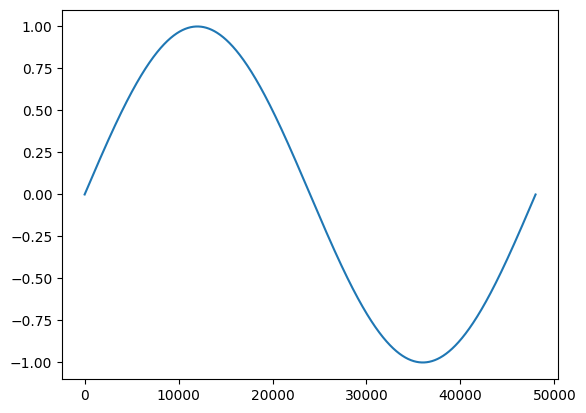

In [74]:

# Delegamos en numpy
# En vez procesar cada muestra *i* por separado, calculamos el seno de un array numpy

osc = np.sin(2*np.pi*np.arange(SRATE)/SRATE)
plt.plot(osc)

# Mucho más eficiente! Numpy delega en la librería C para hacer el cálculo de seno de un array completo

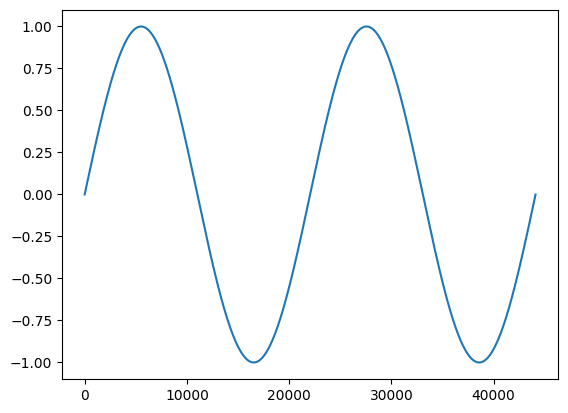

In [5]:
# si queremos frecuencia 2 Hz
osc = np.sin(2*np.pi*np.arange(SRATE)*2/SRATE)
plt.plot(osc)

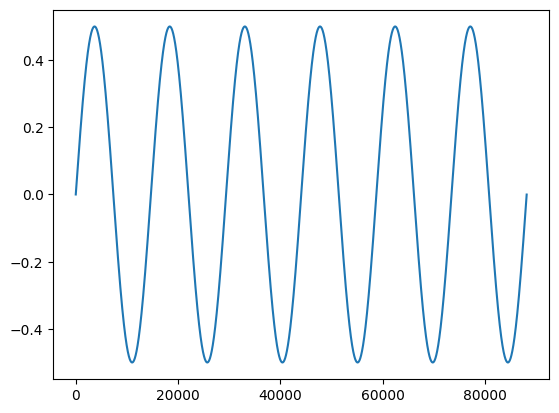

In [6]:
# Generalizando como función
def osc(frec,dur,vol):      
    return vol * np.sin(2*np.pi*np.arange(int(SRATE*dur))*frec/SRATE)

o = osc(3,2,0.5)
plt.plot(o)

In [8]:
## Cómo suena?

import sounddevice as sd

o = osc(440,2,0.2)
sd.play(o,SRATE)

## Otro generador... ruido

Muestras aleatorias con duración y volumen dado


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


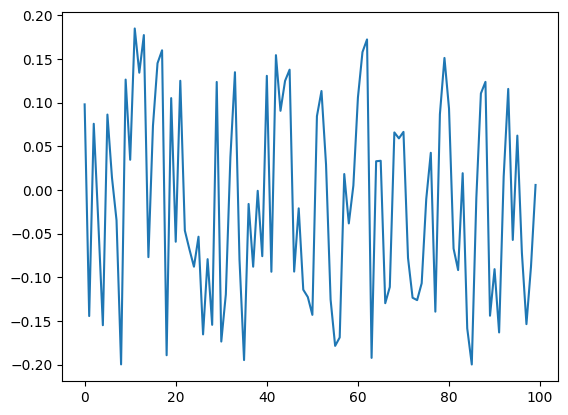

In [11]:

def noise(dur,vol):
    # random(n) devuelve [x0,x1,...xn-1] muestras aleatorias en [0,1]
    # xi*2-1   -> muestra aleatoria en [-1,1]
    # return (vol*(2.0*np.random.random(int(SRATE*dur))-1.0))

    # más directo: random.uniform(low=0.0, high=1.0, size=None)
    return np.float32(vol*np.random.uniform(-1,1,int(SRATE*dur)))
    # por defecto devuelve "float64": hay convertir a "float32"

n = noise(2,0.2)
sd.play(n,SRATE)

# dibujamos las primeras 100 muestras
plt.plot(n[:100])

# Generadores de señal por CHUNKs

La idea es inicializar el oscilador e ir generando señal con sucesivas llamadas a una función **next**

In [1]:
# Generación con CHUNKs, como clase

import numpy as np         
import sounddevice as sd                 

CHUNK = 1024
SRATE = 48000

class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
    
    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(CHUNK))*self.freq/SRATE+self.phase)
        return np.float32(out)

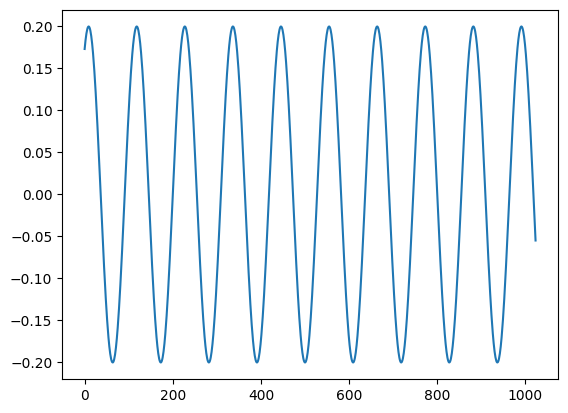

In [6]:
# veamos un chunk
import matplotlib.pyplot as plt
ck = Osc(440,0.2,phase=np.pi/3)
plt.plot(ck.next())

In [5]:
# como suena?
# Generamos varios chunks, los concatenamos y los reproducimos

stream = sd.OutputStream(samplerate=SRATE, blocksize=CHUNK, channels=1)
stream.start()


osc = Osc(110,0.2)

time = 4 # segundos
numChunks = (SRATE//CHUNK)*time # número de chunks para time segundos
for k in range(numChunks):
    samples = osc.next()
    stream.write(np.float32(samples))


stream.stop()       
stream.close()

## Por qué suena mal (pops)?

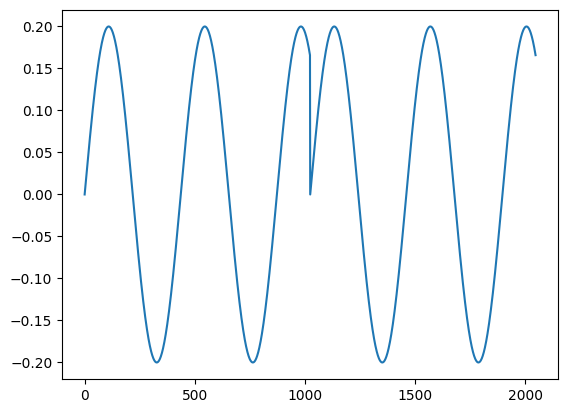

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


chunk1 = osc.next()
chunk2 = osc.next()

total = np.concatenate((chunk1,chunk2))

plt.plot(total)

### Cómo se arregla? 

El oscilador tiene que llevar **memoria del último frame** generado (fase) para generar el siguiente chunk a partir de ese valor

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0 # frame inicial

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        
        self.frame += CHUNK # actualizamos el frame
        return out
    
    


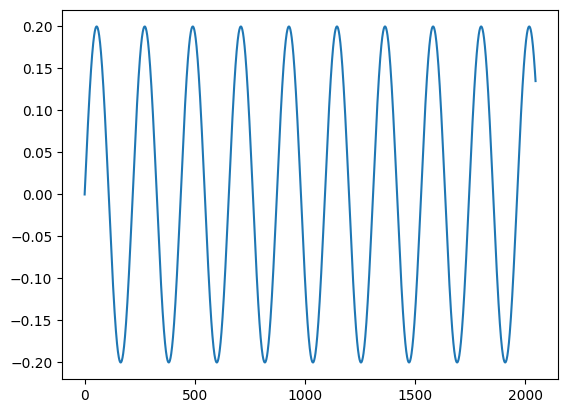

In [9]:
# Dibujemos

osc = Osc(220,0.2)

# los mismos 2 chunks de antes
chunk1 = osc.next()
chunk2 = osc.next()

total = np.concatenate((chunk1,chunk2))

plt.plot(total)

In [12]:
# como suena?

stream = sd.OutputStream(samplerate=SRATE, blocksize=CHUNK, channels=1)
stream.start()

time = 2 # segundos
numChunks = (SRATE//CHUNK)*time # número de chunks para time segundos
for k in range(numChunks):
    samples = osc.next()
    stream.write(np.float32(samples))

stream.stop()       

# Otras formas de onda

El seno es la forma clásica de onda y las más natural, pero hay otras formas interesantes

<img src="media/waves.png" width="60%" />"

Podemos generarlas "manualmente" pero la lisbrería scipy ya las incorpora

In [35]:
# Extendemos la clase Osc para que acepte diferentes tipos de onda

import numpy as np         
import sounddevice as sd   
import scipy.signal as sg 
              

CHUNK = 1024
SRATE = 48000

class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0
        self.shape = shape

    def next(self):    
        if self.shape=='sin':
            out = np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='square':
            out = sg.square(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='sawtooth':
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='triangle':
            # Ojo, la triangular no existe como tal en scipy, pero podemos hacerla con dos sawtooth
            # el 2º parametro define la "rampa" la subida y bajada (ver documentacion)
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase,0.5)
        self.frame += CHUNK

        return np.float32(self.amp*out)
    


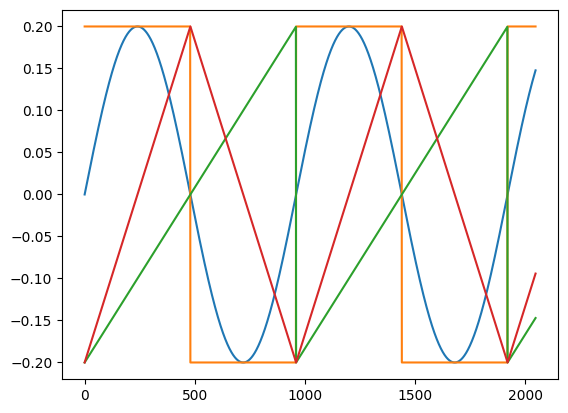

In [36]:

import matplotlib.pyplot as plt
%matplotlib inline

for sh in ['sin','square','sawtooth','triangle']:
    osc = Osc(50,0.2,shape=sh)
    plt.plot(np.concatenate((osc.next(),osc.next())))


In [38]:

# como suenan?

stream = sd.OutputStream(samplerate=SRATE, blocksize=CHUNK, channels=1)
stream.start()

time = 2 # segundos
numChunks = (SRATE//CHUNK)*time # número de chunks para time segundos


for sh in ['sin','square','sawtooth','triangle']:
    osc = Osc(220,0.2,shape=sh)
    print(f'shape: {sh}')
    for k in range(numChunks):
        samples = osc.next()
        stream.write(np.float32(samples))

stream.stop()       



shape: sin
shape: square
shape: sawtooth
shape: triangle


# Por qué suenan distintas al seno??

Una señal sinusoidal produce una *frecuecia pura*

- Que frecuencias producen las ondas cuadradas, triangulares y de diente de sierra?

Ver contenido armónico en https://en.wikipedia.org/wiki/Square_wave

shape: sin


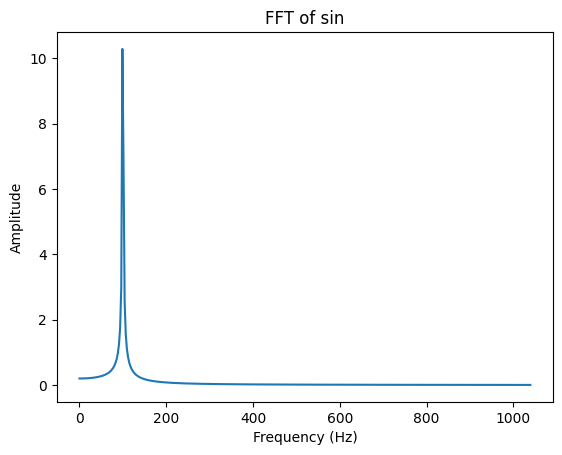

shape: square


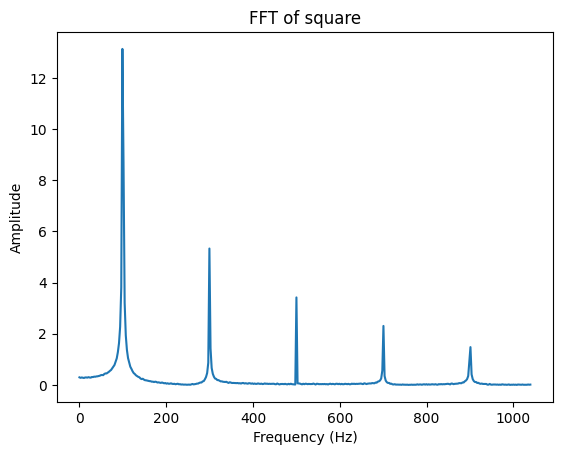

shape: sawtooth


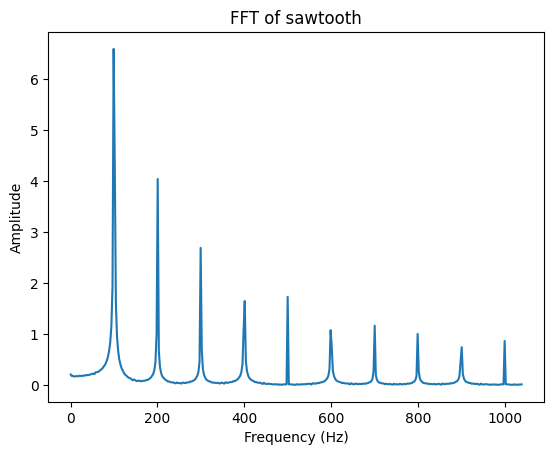

shape: triangle


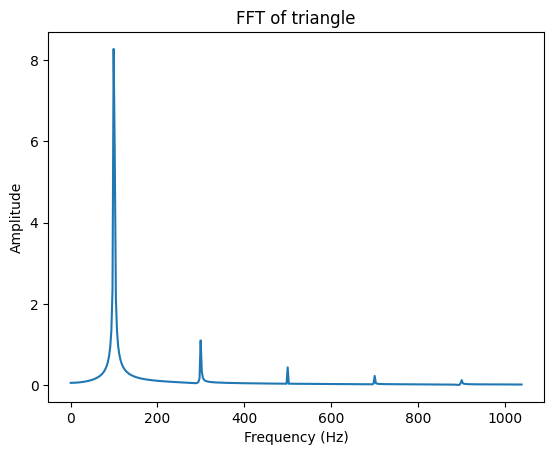

In [72]:
# Qué frecuencias tienen?
# Un sencillo análisis de espectro

time = 0.4 # segundos de señal generada para analizar
numChunks = int(SRATE/CHUNK*time) # número de chunks para obtener la señal de esa duración

# eje de tiempo para graficar
t = np.linspace(0, time, int(SRATE * time), endpoint=False)

# frecuencia del oscilador que vamos a analizar
f = 100
for sh in ['sin','square','sawtooth','triangle']:
    osc = Osc(f,0.2,shape=sh)
    print(f'shape: {sh}')
    samples = np.empty((1,),dtype=np.float32)
    for k in range(numChunks):
        samples = np.concatenate([samples,osc.next()])

    fft_result = np.abs(np.fft.rfft(samples,norm='ortho'))
    freq = np.fft.rfftfreq(samples.size, d=1/SRATE)
        
    # Plotting the spectrum
    plt.plot(freq[:f*4], fft_result[:f*4])
    plt.title(f'FFT of {sh}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.show()




# Ojo

La señal cuadrada es *no band-limited*:
- produce la serie infinita de armónicos para la frecuencia fundamental dada
- esto produce aliasing...

Para profundizar (y escuchar) ver:

https://www.nayuki.io/page/band-limited-square-waves

# Desde aquí\...

- Otras formas de onda: cuadrada, triangular, diente de sierra (ejercicios)

- Composición de ondas: modelos de síntesis aditiva, FM...

- Otros modelos de síntesis.

- Filtros y efectos

Un tutorial sobre síntesis en Python:

<https://python.plainenglish.io/making-a-synth-with-python-oscillators-2cb8e68e9c3b>

Muy mejorable con NumPy!!